In [282]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore Future Warning regarding pysal/spaghetti
warnings.simplefilter(action='ignore', category=UserWarning) # Ignore User Warning regarding SQl.Alchemy from pymssql

from pysal.lib import weights
from pysal.explore import esda
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import contextily
import os

# Rasterio Installation bug where the Environment variable 'PROJ_LIB' isn't looking in the right file for 'Proj.db' SQLlite Database
# After installation, you need to find the folder where rasterio is storing the 'Proj.db' file
os.environ['PROJ_LIB'] = '/Users/ahadhussain/opt/anaconda3/lib/python3.9/site-packages/rasterio/proj_data/'

import geopandas as gpd
from shapely.geometry import Point # Shapely for converting latitude/
import pandas as pd
import pymssql

database = "Pushing-P-DB"
table = "dbo.Master_Table"
user = "pushing_p"
password  = "t3stP@ssword"
server = "gen10-data-fundamentals-22-02-sql-server.database.windows.net"


# Retrieve Training Data for Geographically Weighted Regression Model
conn = pymssql.connect(server, user, password, database)


# Query select all rows from SQL table to insert in DataFrame
query = f'SELECT * FROM {table}'
df = pd.read_sql(query, conn)

In [283]:
df.dtypes

State                                                    object
County                                                   object
City                                                     object
Unemployment Rate (16 & Over)                           float64
Median Household Income                                   int64
City Population                                           int64
Uninsured Population                                      int64
NUI, Under 6 years                                        int64
NUI, 6-18 years                                           int64
NUI, 19 to 25 years                                       int64
NUI, 26 to 34 years                                       int64
NUI, 35 to 44 years                                       int64
NUI, 45 to 54 years                                       int64
NUI, 55 to 64 years                                       int64
NUI, 65 years and older                                   int64
NUI, Men                                

In [284]:
# Convert columns to proper data types
df[['State','County','City']] = df[['State','County','City']].astype(str)

# # Make new column with % of Uninsured (Dependent Variable)
# df['% Uninsured (2019)'] = df['Number of Unemployed People (2019)']/df['Population Estimate (2019)'] * 100

# # Make new columns with natural log of metric (Independent Variables)
# df['Log NUP'] = df['Number of Unemployed People (2019)'].apply(lambda x: np.log(x))
# df['Log MHI'] = df['Median Household Income (2019)'].apply(lambda x: np.log(x))



In [285]:
df.head()

,State,County,City,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude
0,New Jersey,Burlington County,Medford Township,4.2,133796,23166,266,0,75,53,...,171,95,203,0,0,8,0,36,39.866183,-74.839016
1,New Jersey,Atlantic County,Northfield,6.5,84464,7926,465,27,20,0,...,166,299,418,0,0,8,0,39,39.370394,-74.550155
2,New Jersey,Atlantic County,Mullica Township,5.1,79155,5869,285,18,21,55,...,164,121,285,0,0,0,0,0,39.576782,-74.716629
3,New Jersey,Cumberland County,Stow Creek Township,6.3,65313,1046,35,0,0,11,...,24,11,26,0,9,0,0,0,39.448732,-75.352878
4,New Jersey,Hudson County,Hoboken,3.2,153438,53283,1428,0,0,112,...,674,754,717,36,0,288,0,74,40.743991,-74.032363


In [286]:
df.shape

(565, 25)

In [287]:
# Collinearity Test using Variance Inflation Factors (VIFs)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# compute the vif for all given features
def Compute_VIF(considered_features):
    
    X = df[considered_features].copy()
    # the calculation of variance inflation requires a constant

    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif.loc[:,'Variable']!='intercept'].sort_values(by='VIF',ascending=False)
    return vif

In [288]:
# Int64 and Float64 columns contain numerical data
numerical_data = df.select_dtypes(include=['int64','float64'])
numerical_data.head()

,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, Under 6 years","NUI, 6-18 years","NUI, 19 to 25 years","NUI, 26 to 34 years","NUI, 35 to 44 years","NUI, 45 to 54 years",...,"NUI, Men","NUI, Women","NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude
0,4.2,133796,23166,266,0,75,53,75,25,31,...,171,95,203,0,0,8,0,36,39.866183,-74.839016
1,6.5,84464,7926,465,27,20,0,82,234,40,...,166,299,418,0,0,8,0,39,39.370394,-74.550155
2,5.1,79155,5869,285,18,21,55,22,29,75,...,164,121,285,0,0,0,0,0,39.576782,-74.716629
3,6.3,65313,1046,35,0,0,11,5,10,9,...,24,11,26,0,9,0,0,0,39.448732,-75.352878
4,3.2,153438,53283,1428,0,0,112,581,157,360,...,674,754,717,36,0,288,0,74,40.743991,-74.032363


In [289]:
# Make copy of numerical data (makes testing easier)
indep_variables = numerical_data.copy()

# Add constant to Uninsured Population (prevent infinities when taking natural log of 0)
indep_variables['Uninsured Population'] = indep_variables['Uninsured Population'] + 1

# # Drop City Population
# indep_variables.drop('City Population',axis=1,inplace = True)

# Drop Men
indep_variables.drop('NUI, Men',axis=1,inplace = True)

# Drop Women
indep_variables.drop('NUI, Women',axis=1,inplace = True)

# Drop 35 to 44 years
indep_variables.drop('NUI, 35 to 44 years',axis=1,inplace = True)

# Drop 45 to 54 years
indep_variables.drop('NUI, 45 to 54 years',axis=1,inplace = True)

# Drop 26 to 34 years
indep_variables.drop('NUI, 26 to 34 years',axis=1,inplace = True)

# Drop 55 to 64 years
indep_variables.drop('NUI, 55 to 64 years',axis=1,inplace = True)

# Drop 19 to 25 years
indep_variables.drop('NUI, 19 to 25 years',axis=1,inplace = True)

# Drop 6-18 years
indep_variables.drop('NUI, 6-18 years',axis=1,inplace = True)

# Drop Under 6
indep_variables.drop('NUI, Under 6 years',axis=1,inplace = True)

# Drop Under 65 years and older
indep_variables.drop('NUI, 65 years and older',axis=1,inplace = True)

# Create a copy of this dataframe
df = indep_variables.copy()

# Drop Dependent Variable
indep_variables.drop('Uninsured Population',axis=1,inplace = True)


Compute_VIF(list(indep_variables))

,Variable,VIF
2,City Population,6.087394
3,"NUI, White",4.754324
8,"NUI, Other Races",3.157460
4,"NUI, African American",2.904907
5,"NUI, American Indian & Alaska Native Population",2.426085
6,"NUI, Asians",2.110550
9,Latitude,1.495193
1,Median Household Income,1.441811
10,Longitude,1.393572
7,"NUI, Native Hawaiians & Pacific Islanders Popu...",1.201395


In [290]:
# creating a geometry column 
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [291]:
gdf.head()

,Unemployment Rate (16 & Over),Median Household Income,City Population,Uninsured Population,"NUI, White","NUI, African American","NUI, American Indian & Alaska Native Population","NUI, Asians","NUI, Native Hawaiians & Pacific Islanders Population","NUI, Other Races",Latitude,Longitude,geometry
0,4.2,133796,23166,267,203,0,0,8,0,36,39.866183,-74.839016,POINT (-74.83902 39.86618)
1,6.5,84464,7926,466,418,0,0,8,0,39,39.370394,-74.550155,POINT (-74.55015 39.37039)
2,5.1,79155,5869,286,285,0,0,0,0,0,39.576782,-74.716629,POINT (-74.71663 39.57678)
3,6.3,65313,1046,36,26,0,9,0,0,0,39.448732,-75.352878,POINT (-75.35288 39.44873)
4,3.2,153438,53283,1429,717,36,0,288,0,74,40.743991,-74.032363,POINT (-74.03236 40.74399)


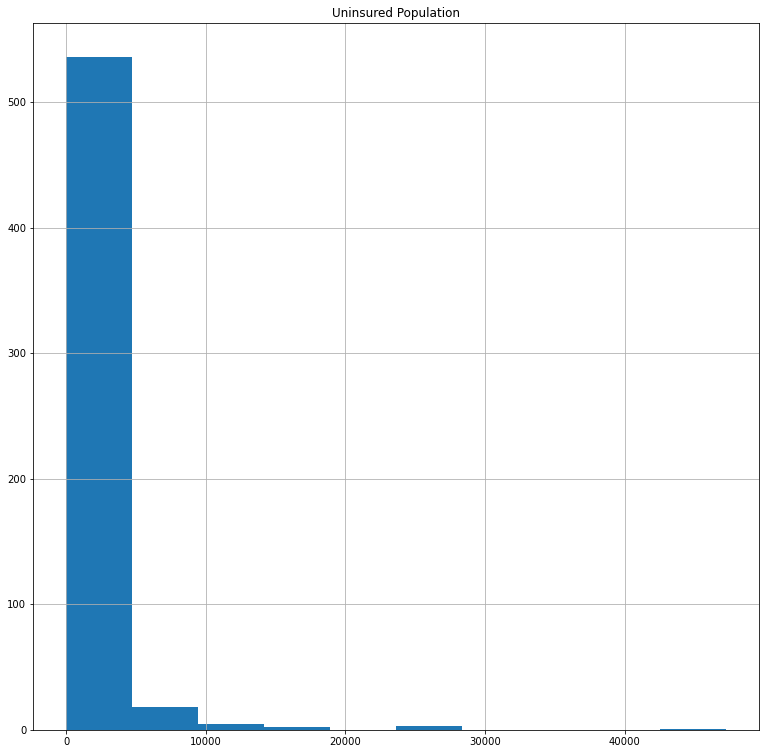

In [292]:
# Create Histogram of Target Variable
gdf.hist(column='Uninsured Population');

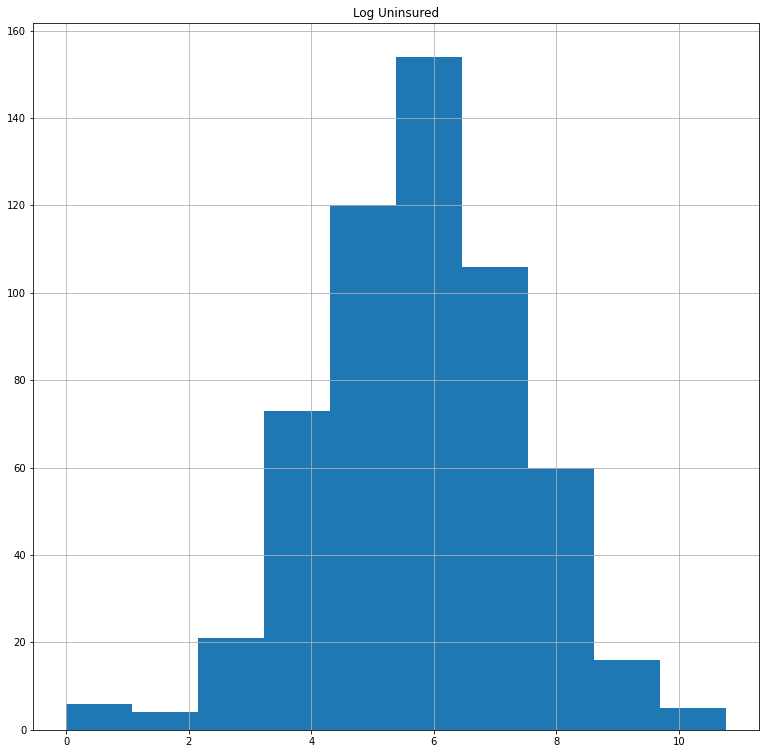

In [293]:
# Smooth skewness by taking log of target variable
gdf['Log Uninsured'] = gdf['Uninsured Population'].apply(lambda x: np.log(x))
gdf.drop('Uninsured Population', axis=1, inplace=True)
gdf.hist(column = 'Log Uninsured');

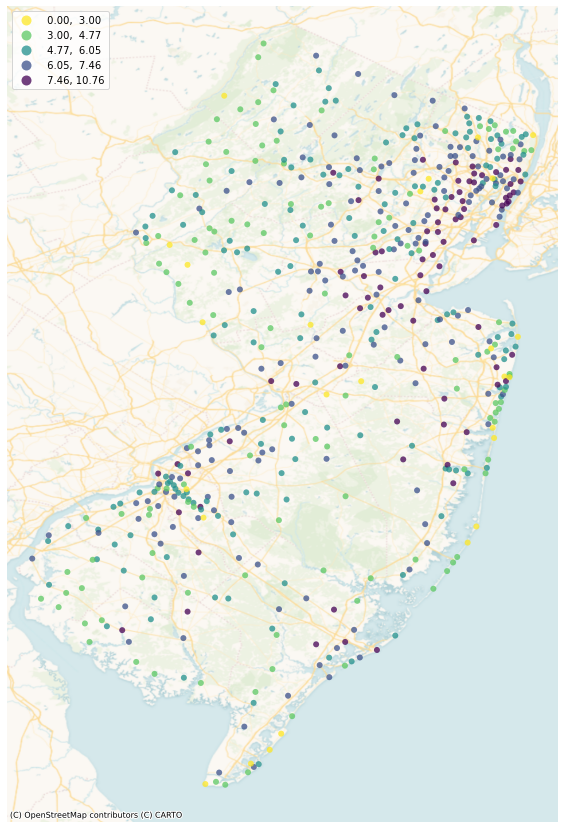

In [294]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(15, 15))

# Build choropleth
gdf.plot(
    column='Log Uninsured', 
    cmap='viridis_r', 
    scheme='natural_breaks',
    k=5, 
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75, 
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax
)
# Add basemap
contextily.add_basemap(
    ax, 
    crs=gdf.crs, 
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes


ax.set_axis_off();

In [295]:
from pysal.model import spreg
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    gdf[['Log Uninsured']].values, 
    # Independent variables
    gdf.drop(['Log Uninsured','geometry'], axis = 1).values,
    # Dependent variable name
    name_y='Uninsured Population', 
    # Independent variable name
    name_x= list(gdf.drop(['Log Uninsured','geometry'], axis = 1).columns)
)

In [296]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :Uninsured Population                Number of Observations:         565
Mean dependent var  :      5.7634                Number of Variables   :          12
S.D. dependent var  :      1.6597                Degrees of Freedom    :         553
R-squared           :      0.5747
Adjusted R-squared  :      0.5663
Sum squared residual:     660.664                F-statistic           :     67.9400
Sigma-square        :       1.195                Prob(F-statistic)     :   3.449e-95
S.E. of regression  :       1.093                Log likelihood        :    -845.889
Sigma-square ML     :       1.169                Akaike info criterion :    1715.777
S.E of regression ML:      1.0813                Schwarz criterion     :    1767.819

---------------------------------------------------------------------

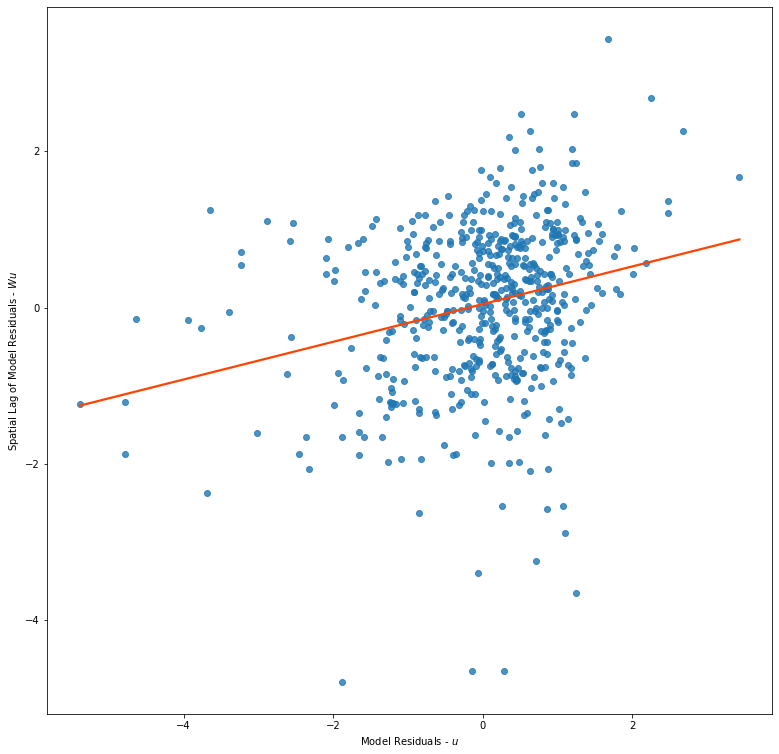

In [297]:
knn = weights.KNN.from_dataframe(gdf, k=1)
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    m1.u.flatten(), 
    lag_residual.flatten(), 
    line_kws=dict(color='orangered'),
    ci=None
)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

### Our prediction errors tend to cluster! Above, we show the relationship between our prediction error at each site and the prediction error at the site nearest to it.

### Here, we’re using this nearest site to stand in for the surroundings of a County. This means that, when the model tends to **over-predict** a given County's % Uninsured, sites around that County are *ALSO* more likely to also be over-predicted!

### An interesting property of this relationship is that it tends to stabilize as the number of nearest neighbors used to construct each County's surroundings increases

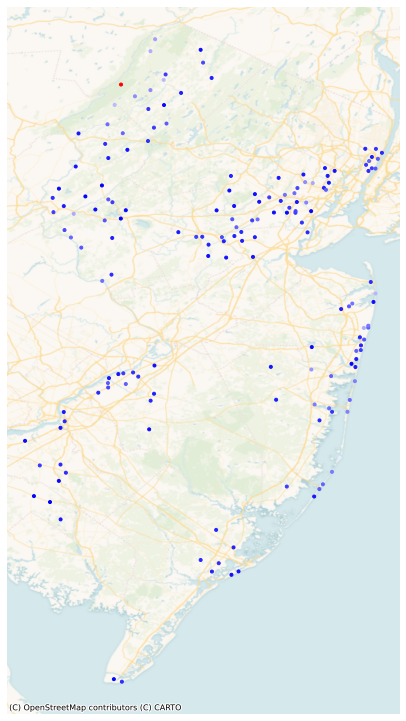

In [298]:
# Re-weight W to 20 nearest neighbors
plt.rcParams["figure.figsize"] = (13,13);
knn.reweight(k=20, inplace=True)

# Row standardise weights
knn.transform = 'R'
# Run (Local Spatial Autocorrelation) LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)

# q values: 1 HH, 2 LH, 3 LL, 4 HL

# Select only LISA cluster cores where the model overpredicts
error_clusters = (outliers.q % 2 == 1)
# Filter out non-significant clusters
error_clusters &= (outliers.p_sim <= .05)
# Add `error_clusters` and `local_I` columns
ax = gdf.assign(
    error_clusters = error_clusters,
    local_I = outliers.Is
# Retain error clusters only
).query(
    "error_clusters"
# Sort by I value to largest plot on top
).sort_values(
    'local_I'
# Plot I values
).plot(
    'local_I', cmap='bwr', marker='.'
)
# Add basemap
contextily.add_basemap(ax, crs=gdf.crs,
source=contextily.providers.CartoDB.VoyagerNoLabels)
# Remove axes
ax.set_axis_off();


- #### Here, we are measuring spatial autocorrelation for our Counties using **Local Moran's I** Statistics. 
- #### **ESDA** is Exploratory Spatial Data Analysis
- #### [What is Moran's I?](https://www.statisticshowto.com/morans-i/#:~:text=What%20is%20Moran's%20I%3F,the%20observations%20are%20not%20independent) Moran's I is a correlation coefficient that measures the overall spatial autocorrelation of your data set. In other words, it measures how one object is similar to others surrounding it. If objects are attracted (or repelled) by each other, it means that the observations are not independent.

- #### The highlighted areas tend to be locations where our model significantly **overpredicts** the % Uninsured both for that specific observation and observations in its immediate surroundings. 
- #### This is critical since, if we can identify how these areas are structured — in other words, if they have a *consistent* geography that we can model — then we might make our predictions even better, or at least not systematically mis-predict prices in some areas while correctly predicting prices in other areas

In [299]:
# variable_names = [
#     'Log NUP',
#     'Log MHI',
#     'Unemployment Rate (2019)',
# ]

# m5 = spreg.OLS_Regimes(
#     # Dependent variable
#     gdf[['% Uninsured (2019)']].values, 
#     # Independent variables
#     gdf[variable_names].values,
#     # Variable specifying neighborhood membership
#     gdf['Urban Category'].tolist(),
#     # Allow the constant term to vary by group/regime
#     constant_regi='many',
#     # Allow separate sigma coefficients to be estimated
#     # by regime (False so a single sigma)
#     regime_err_sep=False,
#     # Dependent variable name
#     name_y='% Uninsured', 
#     # Independent variables names
#     name_x=variable_names
# )

In [300]:
# print(m5.summary)

In [301]:
# # Estimated Linear Regression Coefficients
# m5.betas

In [302]:
# acs = cenpy.products.ACS()
# sd_pop = acs.from_msa(
#     "San Diego, CA",
#     level = "tract",
#     variables=['B02001_001E']
# )

In [303]:
# sd_pop